# Microproyecto 1
 **Asignatura: Machine Learning No Supervisado**
 
 **Estudiantes:** 
 * Jordi N. Sánchez A. 
 * Víctor D. Pérez D.
 
 **Version de python** >= 3.8
 
 **Requerimientos adicionales:** Powershell

In [116]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, MiniBatchKMeans
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import subprocess
import json


Declaración de constantes y variables globales

In [117]:
# CONSTANTES

ROOT_PATH = 'images'
RESIZER_PROPORTION = 0.3
PS_SCRIPT_PATH = "utils\\trainer.ps1"
PYTHON_SCRIPT_PATH = "utils\\train_parallel.py"
VENV_PATH = ".venv"
REQUIREMENTS_PATH = "requirements.txt"
KMIN = "3"
KMAX = "10"


trainer_parameters = [ROOT_PATH, KMIN, KMAX]

Funciones y clases auxiliares

In [118]:
def load_images(root_path, file_names, normalize=True):
    """
    Retorna una lista con arreglos de números. Cada arreglo representa una imagen RGB.
    
    Parametros:
    root_path : str
        Directorio raíz de las imágenes.
    file_names : list
        Lista con los nombres de los archivos de imágenes.
    flatten : bool, opcional
        Si es True, aplana las imágenes a una lista de píxeles de tres dimensiones.
    normalize : bool, opcional
        Si es True, normaliza los valores de píxeles al rango [0, 1].
    """
    image_list = list()
    for file in file_names:
        img = cv2.imread(os.path.join(root_path, file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if normalize:
            img = img / 255.0
        image_list.append(img)
    return image_list

In [119]:
# Cargar imagenes en carpeta
img_files = os.listdir(ROOT_PATH)
img_files

['img1.jpg', 'img2.jpg', 'img3.jpg', 'img4.jpg', 'img5.jpg']

In [120]:
# Cargar imágenes encontradas
img_list = load_images(ROOT_PATH, img_files, normalize=True)
plt.figure(figsize=(10, 5))

for i in range(5):
    plt.subplot(1, len(img_files), i+1)
    plt.title (f"Imagen {i}")
    plt.imshow(img_list[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

**Al correr la siguiente celda, por favor seleccione el indice de la imagen que desee usar**

In [ ]:
image_number = input('Ingrese el número de la imagen que desea analizar: ')
image_number = int(image_number)
print("Imagen seleccionada: ", image_number)

trainer_parameters.append(str(image_number))

Imagen seleccionada:  4


Creación de las clases para el pipeline

In [ ]:
class Resizer(BaseEstimator, TransformerMixin):
    """
    Redimensiona una imagen a un tamaño específico.
    
    Parametros:
    image : numpy.ndarray
        Arreglo de números que representa una imagen RGB.
    size : tuple, opcional
        Tamaño al que se redimensionará la imagen.
    """
    def __init__(self, proportion=0.5):
        self.proportion = proportion
    
    def fit(self, X, y=None):
        print(f"fit size: {X.shape}")
        self.size = (int(X.shape[0] * self.proportion), int(X.shape[1] * self.proportion))
        return self
    
    def transform(self, X):
        print(f"transform size: {self.size}")
        return cv2.resize(X, dsize=(self.size[1],self.size[0]))

In [ ]:
class Flatter(BaseEstimator, TransformerMixin):
    """
    Aplana una imagen a una lista de píxeles de tres dimensiones.
    
    Parametros:
    image : numpy.ndarray
        Arreglo de números que representa una imagen RGB.
    """
    def __init__(self):
        pass

    def transform(self, X, **transform_params):
        return X.reshape((-1, 3))

    def fit(self, X, y=None, **fit_params):
        return self

### Importante

Las siguientes celdas ejecutarán un script de powershell que a su vez correrá un script en python, cuyo objetivo es entrenar varios modelos de kmeans, según los hiperparámetros configurados al inicio de este notebook de forma concurrente. Esto con el proposito de disminuir el tiempo de entrenamiento. Se sugiere revisar el script de powershell antes de correrlo. Este se encuentra en  ***utils/trainer.ps1***.

La primera vez ejecutando, tomará más tiempo debido a que es necesario crear un .venv con otras librerias necesarias para la concurrencia (requirements.txt). 

In [ ]:
# Construct the PowerShell command
powershell_command = [
    "powershell.exe",
    "-File", PS_SCRIPT_PATH,
    "-scriptPath", PYTHON_SCRIPT_PATH,
    "-venvPath", VENV_PATH,
    "-requirementsFile", REQUIREMENTS_PATH, 
    "-rootPath", trainer_parameters[0], 
    "-kmin",trainer_parameters[1], 
    "-kmax", trainer_parameters[2], 
    "-imagePicker", trainer_parameters[3]
]

powershell_command = ' '.join(powershell_command, )
print(powershell_command)


powershell.exe -File utils\trainer.ps1 -scriptPath utils\train_parallel.py -venvPath .venv -requirementsFile requirements.txt -rootPath images -kmin 3 -kmax 10 -imagePicker 4


Ejecución del script de powershell.

**PD: La concurrencia puede realentizar temporalmente el ordenador desde donde se ejecuta este script.**

In [ ]:
output = subprocess.run(powershell_command, text=True, stdout=subprocess.PIPE)
# Print the output
print("Output:", output.stdout)


Output: Requirement already satisfied: scikit-learn in c:\users\vic_p\onedrive\documents\github\color-palette-generator\.venv\lib\site-packages (from -r requirements.txt (line 1)) (1.4.1.post1)
Training models in parallel...
root_path:  images
kmin:  3
kmax:  10
image_picker:  4
Loading images
Resizing images
Training completed
{"3": 0.8080561459964029, "4": 0.7607766038241351, "5": 0.5300226158454833, "6": 0.5129677874019086, "7": 0.49578193889708017, "8": 0.48713526757907893, "9": 0.4705116835473098, "10": 0.45605316551081343}



In [ ]:
# Tomar el diccionario de tipo {K: Silhuete score}
last_line = output.stdout.strip().split('\n')[-1]
scores = json.loads(last_line)
scores

{'3': 0.8080561459964029,
 '4': 0.7607766038241351,
 '5': 0.5300226158454833,
 '6': 0.5129677874019086,
 '7': 0.49578193889708017,
 '8': 0.48713526757907893,
 '9': 0.4705116835473098,
 '10': 0.45605316551081343}

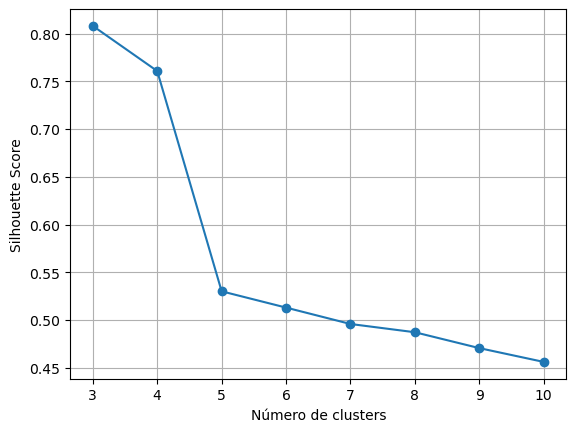

In [ ]:
# Graficar coeficiente de silhuetas
scores_list = [score for _ ,score in scores.items()]
plt.plot(range(int(KMIN),int(KMAX)+1), scores_list, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show()

Selección del k para el coeficiente más alto

In [ ]:
num_clusters = int(max(scores, key=lambda k: scores.get(k)))
num_clusters

3

### Creación del pipeline de entrenamiento

In [ ]:
# Pipeline creation
pipe = Pipeline([("resizer", Resizer()), ("flat_transform", Flatter()), ("model", KMeans())])
pipe.set_params(model__n_clusters=num_clusters)
pipe.set_params(resizer__proportion=RESIZER_PROPORTION)
result = pipe.fit(img_list[image_number])
labels = result.named_steps["model"].labels_
centroids = result.named_steps["model"].cluster_centers_
img_resized = result.named_steps["resizer"].transform(img_list[image_number])
print(img_resized.shape)
print(img_list[image_number].shape)

fit size: (1382, 1849, 3)
transform size: (691, 924)


c:\Users\vic_p\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


transform size: (691, 924)
(691, 924, 3)
(1382, 1849, 3)


Reconstrucción y visualización de la imagen

In [ ]:
centroids_scaled = centroids*255

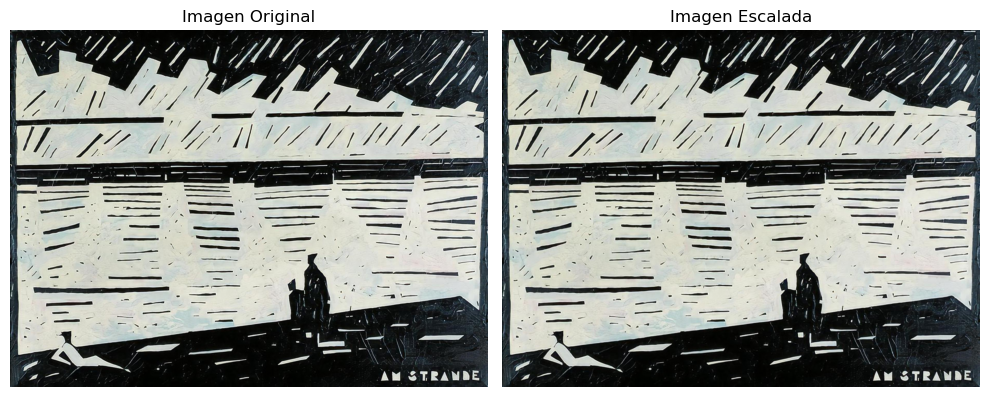

In [ ]:
# Show image
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Imagen Original')
plt.imshow(img_list[image_number])
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Imagen Escalada')
plt.imshow(img_resized)
plt.axis('off')

plt.tight_layout()
plt.show()

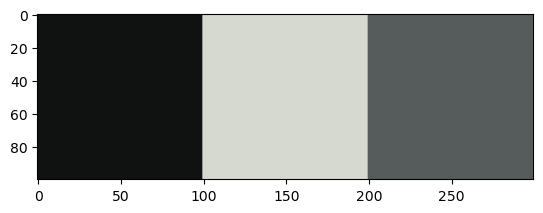

In [ ]:
# Palette generation

generated_pallete = 255 * np.ones(shape=[100, 100*len(centroids_scaled), 3], dtype=np.uint8)

for i, color in enumerate(centroids_scaled):
    cv2.rectangle(generated_pallete, pt1=(i*100,0), pt2=((i+1)*100,200), color=color, thickness=-1)

plt.imshow(generated_pallete)

plt.show()